In [19]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [20]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [21]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [22]:
scale = 10

In [23]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

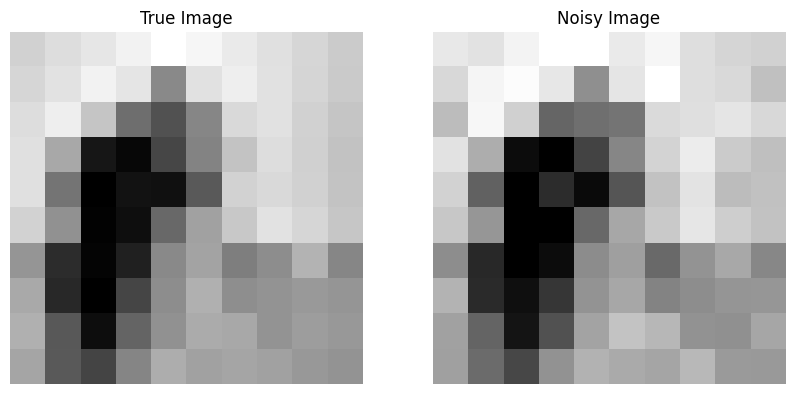

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [25]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [26]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1504
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      281
                     variables with only lower bounds:      101
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0796127e-01 1.10e-02 5.61e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [27]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

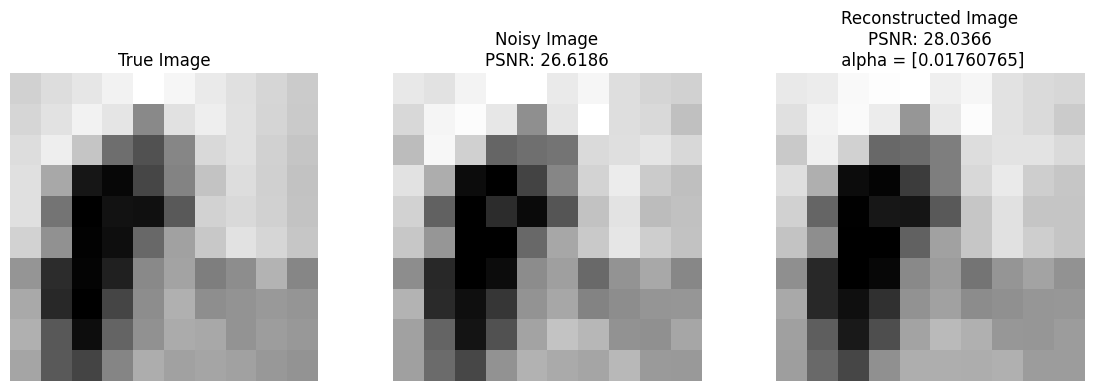

In [28]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [29]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [30]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [31]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 8.94849132e-01  9.04501744e-01  9.54520156e-01  9.67740509e-01
  9.77233915e-01  9.16972985e-01  9.41304545e-01  8.68185561e-01
  8.36928867e-01  8.26899724e-01  8.61566609e-01  9.34025050e-01
  9.55774537e-01  9.05930335e-01  5.87792438e-01  8.91467873e-01
  9.65647169e-01  8.69927842e-01  8.38398454e-01  7.83942967e-01
  7.75530806e-01  9.19525219e-01  8.04075092e-01  4.18616601e-01
  4.33602616e-01  4.99030373e-01  8.50233471e-01  8.72418396e-01
  8.72432860e-01  8.36829599e-01  8.58125594e-01  6.81147012e-01
  7.56502742e-02  4.84434805e-02  2.59746454e-01  4.99193439e-01
  8.29406757e-01  8.98819150e-01  7.95244203e-01  7.62898429e-01
  8.06678737e-01  4.04479133e-01  3.50812789e-02  1.18199108e-01
  1.08374966e-01  3.65917881e-01  7.65071429e-01  8.64600221e-01
  7.59974922e-01  7.60411137e-01  7.57231080e-01  5.58916861e-01
  3.05138877e-02  3.06346325e-02  3.96569914e-01  6.29405070e-01
  7.62912706e-01  8.64654831e-01  7.93572417e-01  7.59272576e-01
  5.60849766e-01  1.80510

In [32]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [33]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=0,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  0.025513270772116077    2.4181478857301126                 1.0

1                 0  0.02542963206665004     2.39882211900419                   0.5

2                 0  0.025429632066882216    1.9284268904265878                0.25

3                -3  0.02551328948799124     1.1201798382529708               0.125

4                 0  0.025513270771434397    1.1920374693159717              0.1375

5                 0  0.02634184228121682     0.7752717542182931      0.061875000000000006

6                 0  0.030723025080690303    0.46522402348937586     0.027843750000000004

7                 0  0.038903009237001074    0.26521080610264486     0.012529687500000003

8                 0  0.04956646805247014     0.15891099753595844     0.0056383593750000014

9                 0  0.059186323384195605    0.10061661678655914     0.0025372617187500008

10                 0  0.0664422242286237      0.06653704592387003     0.0011417677734375004

11                 0  0.07148514011845636     0.046049721013355104    0.0005137954980468752

12                 0  0.07467404241044512     0.0294950203743523      0.00023120797412109383

13                 0  0.07655748143385045     0.01649910625656703     0.00010404358835449222

14                 0  0.07756112868351508     0.009099026652406516    4.68196147595215e-05

15                 0  0.07807927915745447     0.004884384993526334    2.1068826641784675e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.07807927915745447
       x: [ 8.947e-01  9.042e-01 ... -2.336e+00  1.772e-02]
     nit: 17
    info:     status: 0
                   x: [ 8.947e-01  9.042e-01 ... -2.336e+00  1.772e-02]
                   g: [-9.706e-09  3.654e-04 ...  1.323e-15 -1.539e-14]
             obj_val: 0.07807927915745447
              mult_g: [-3.404e-02 -2.713e-08 ...  2.702e-02  4.929e-04]
            mult_x_L: [ 1.118e-11  1.106e-11 ...  0.000e+00  5.644e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 18
    njev: 19

Intermediate fn: 0.07807927915745447

complementarity: 0.004884384993526334

* (STOPPED) Iteration 17: Solving the NLP problem for t = 1e-05 with complementarity: 0.004884384993526334

In [34]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

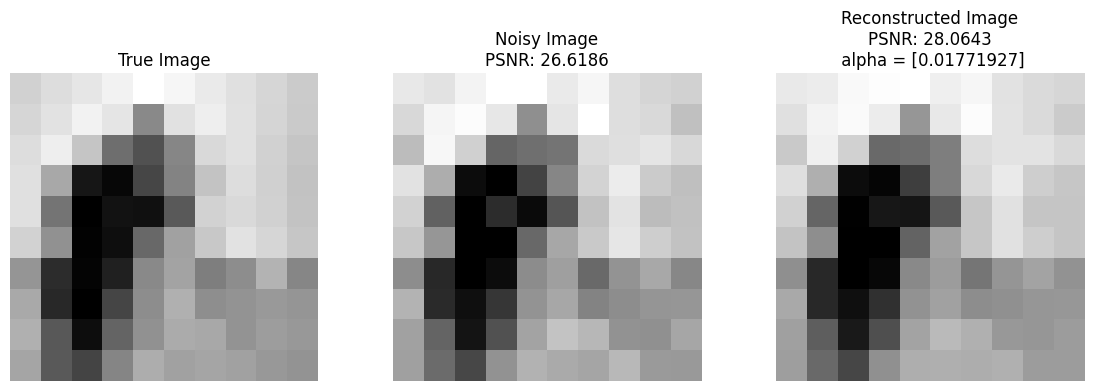

In [35]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)